In [127]:
#
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal as sig
from scipy.optimize import curve_fit
import numpy as np
import copy
import matplotlib as mpl
from matplotlib import cm
color_set=plt.get_cmap('tab10')



class AOE_Compare:
    def __init__(self,noise_sigma=5,Pulse_length=300,Eresolution=True):
        self.Cali_data_path=r"E:\CDEX\C1B_0vbb\ExpData\Cali_Th228_AE.npy"
        self.hit_response_path=r"E:\CDEX\ovbb\WaveSimulation\SimulatedEvents\hit_response.npy"
        self.pss_data_path=r"E:\CDEX\C1B_0vbb\MC_Code\Pulse_Calculate\SAGE-PSS-Basic-1.0\build\OutputFile\C1B_Cali_Th228_Waveform.csv"
        self.Cali_data=None
        self.Cali_Energy=None
        self.Cali_AOE=None
        
        self.Energy=None
        self.Pulse=None
        self.pss_data=None
        self.AOE=None
        self.AOE_normalized=None
        
        self.Qpulse=None
        self.Qpulse_noise=None
        self.Apulse=None
        
        self.Pulse_length=int(Pulse_length)
        self.Eresolution=Eresolution
        
        #参数
        self.noise_sigma=noise_sigma
    
    def read_file(self,lines=None):
        self.pss_data=np.loadtxt(self.pss_data_path,delimiter=',',usecols=range(self.Pulse_length+4),max_rows=lines)
        self.Energy=self.Authenticity_Eresolution(self.pss_data[:,2])
        self.Pulse=self.pss_data[:,4:self.Pulse_length+4]
        self.hit_response=np.load(self.hit_response_path)
        self.Cali_data=np.load(self.Cali_data_path)
        self.Cali_Energy=self.Cali_data[0,:]
        self.Cali_AOE=self.Cali_data[1,:]
        
    #  
    def Qpulse_calculate(self):
        self.Qpulse=self.E_response(self.Partial(self.Pulse,1))
        return self.Qpulse
    def Qpulse_noise_calculate(self):
        self.Qpulse_noise=self.Add_noise(self.Qpulse)
        return self.Qpulse_noise
    def Apulse_calculate(self):
        self.Apulse=self.Partial(self.NMWA(self.Qpulse_noise,5,3),5)
        return self.Apulse
    
    def AOE_calculate(self):
        self.AOE=np.max(self.Apulse,axis=1)/self.Energy
    
    def AOE_normalize(self):
        #以1592keV处A/E分布峰尖为归一化参数
        AE_spec,bins,=np.histogram(self.AOE[np.where(abs(self.Energy-1592.5)<6)],bins=100, range=[0,0.2],density=False)
        max_point=bins[np.argmax(AE_spec)]+(bins[1]-bins[0])/2
        self.AOE_normalized=self.AOE/max_point
        return self.AOE_normalized
    
    def Whole_process_reconstruct(self,line=None):
        self.Qpulse_calculate()
        self.Qpulse_noise_calculate()
        self.Apulse_calculate()
        self.AOE_calculate()
        self.AOE_normalize()
    
    #加能量分辨率
    def E_resolution(self,E):
        return 0.32231948+E*0.00047984
    def Authenticity_Eresolution(self,E_mc):
        if(not self.Eresolution):
            return E_mc
        else:
            E_mc_authentic=np.zeros(E_mc.shape[0])
            E_mc_authentic=np.random.normal(loc=E_mc,scale=E_resolution(E_mc))+E_mc_authentic
            return E_mc_authentic
    
    #Npoint 点差分：
    def Partial(self,x,Npoint):
        py=np.array([1])
        px=np.zeros((Npoint+1,))
        px[0]=1
        px[Npoint]=-1
        y=sig.lfilter(px,py,x,axis=1) #沿着轴1做差分
        return y
    
    #加电子学响应
    def E_response(self,current):
        pulse=current.copy()
        for row in range(current.shape[0]):
            pulse[row,:]=sig.convolve(current[row],self.hit_response,mode='full')[0:self.Pulse_length]
        return pulse
    
    #加噪声
    def Add_noise(self,pulse):
        return pulse+np.random.normal(loc=0,scale=self.noise_sigma,size=pulse.shape)
    
    #计算A/E，输入为Qpulse_noise,带噪声的电荷波形，输出为AOE向量
    def Partial(self,pulse,Npoint):
        py=np.array([1])
        px=np.zeros((Npoint+1,))
        px[0]=1
        px[Npoint]=-1
        return sig.lfilter(px,py,pulse,axis=1)

    def MWA(self,pulse,Npoint):
        py=np.array([1])
        px=np.zeros((Npoint,))+1./Npoint
        return sig.lfilter(px,py,pulse,axis=1)

    def NMWA(self,pulse,Npoint,Ntimes):
        for i in range(Ntimes):
            pulse = MWA(pulse, Npoint)
        return pulse
    ###可以在这里修改比较，求参数
    def Compare_AOE(self,ROI=[[1592.5,6]],AOE_range=[0.6,1.2],bins_=100):
        fig,ax=plt.subplots(1,len(ROI),figsize=(10,6),dpi=300)
        for i in range(len(ROI)):
            ax_=None
            if(len(ROI)==1):
                ax_=ax
            else:
                ax_=ax[i]
            
            ROI_Event_Pss=self.AOE_normalized[np.argwhere((abs(self.Energy-ROI[i][0])<ROI[i][1]))]
            ROI_Event_Cali=self.Cali_AOE[np.argwhere((abs(self.Cali_Energy-ROI[i][0])<ROI[i][1]))]

            spec_pss,bins_pss,patchs_pss=ax_.hist(ROI_Event_Pss,bins=bins_,range=AOE_range,density=True,\
                                                  histtype='step',log=False,linewidth=0.8,color='red',label='simulation')
            spec_cali,bins_cali,patchs_cali=ax_.hist(ROI_Event_Cali,bins=bins_,range=AOE_range,density=True,\
                                                    histtype='step',log=False,linewidth=0.8,color='blue',label='calibration')
            
            ax_.set_xlabel("[%d,%d] A/E"%(ROI[i][0]-ROI[i][1],ROI[i][0]+ROI[i][1]))
            ax_.legend()
            
        plt.show()
            

In [128]:
A=AOE_Compare(noise_sigma=0)
A.read_file()

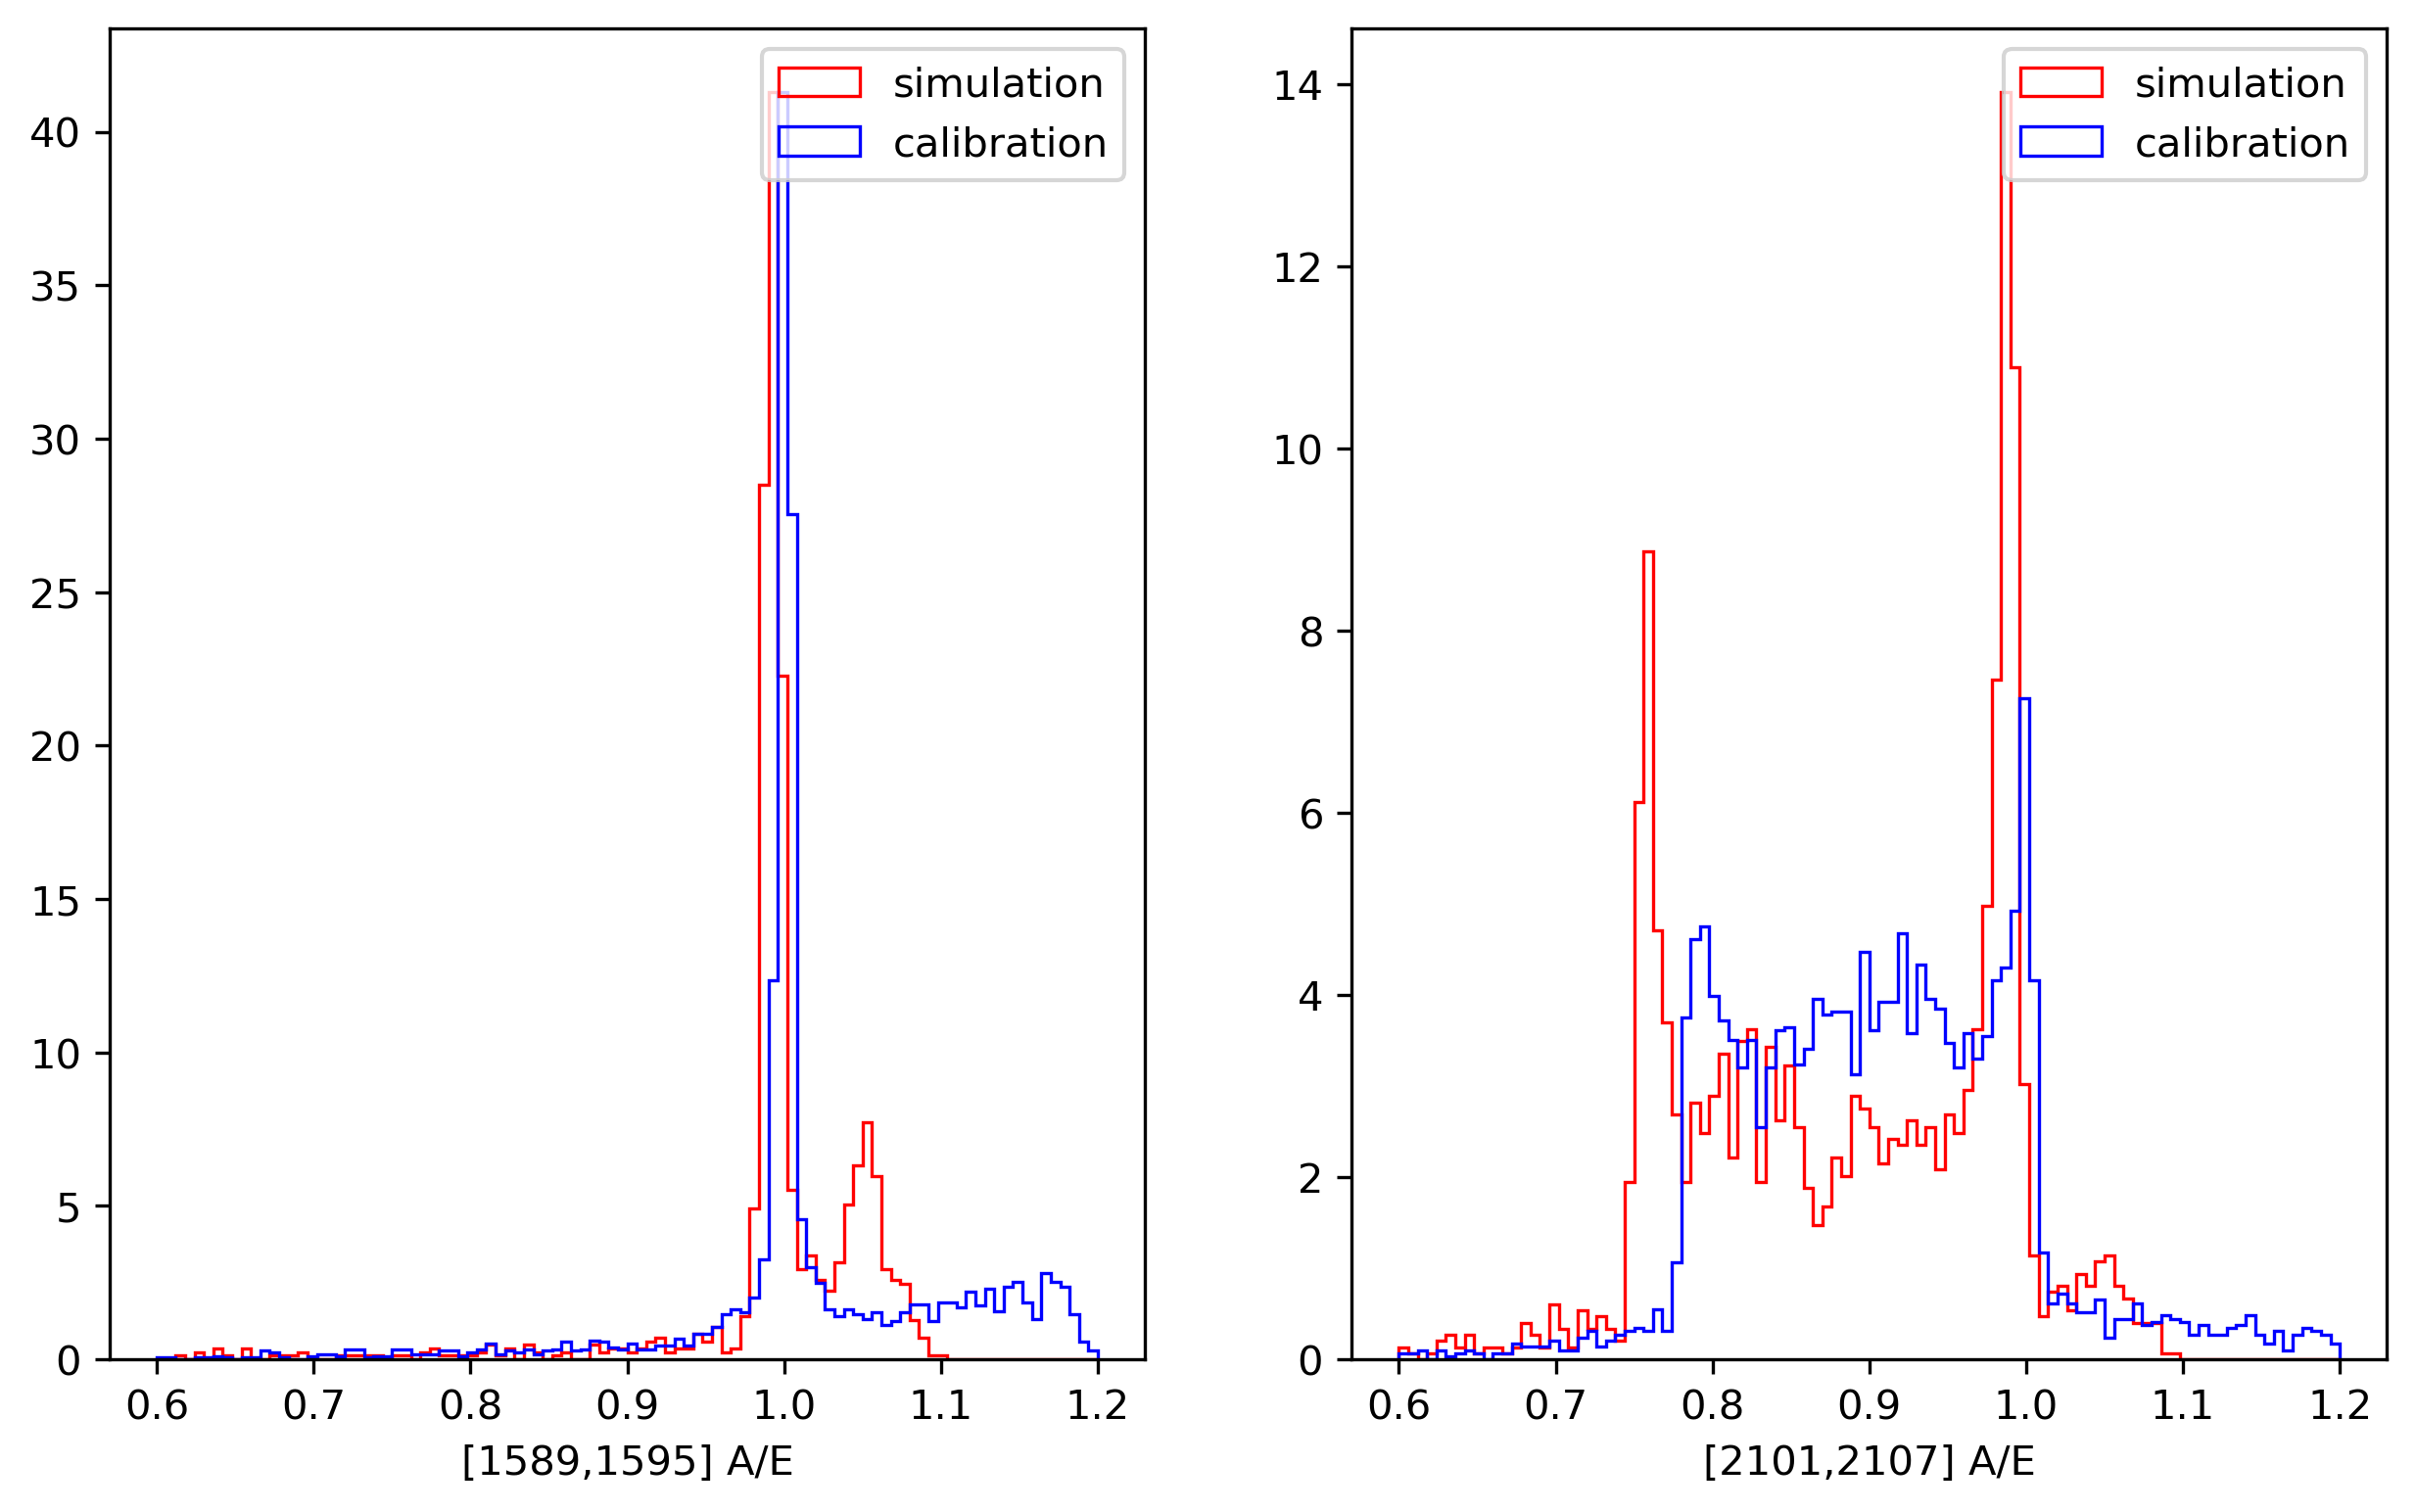

In [134]:
A.noise_sigma=3
A.Whole_process_reconstruct()
A.Compare_AOE(ROI=[[1592,3],[2104,3]])

In [78]:
#从模拟波形库中提取数据：能量，波形
pss_data=np.loadtxt(r"E:\CDEX\C1B_0vbb\MC_Code\Pulse_Calculate\SAGE-PSS-Basic-1.0\build\OutputFile\C1B_Cali_Th228_Waveform.csv",delimiter=',',\
                    usecols=range(304))
Energy=Authenticity_Eresolution(pss_data[:,2])
MaxA=pss_data[:,3]
Pulse=pss_data[:,4:]
print(pss_data.shape)

(106373, 304)


(106373, 300)


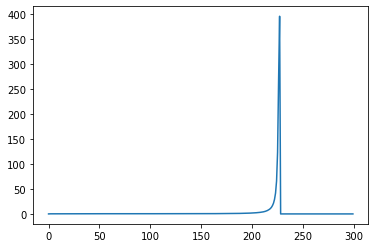

In [53]:
def Partial(x,Npoint):
    py=np.array([1])
    px=np.zeros((Npoint+1,))
    px[0]=1
    px[Npoint]=-1
    y=sig.lfilter(px,py,x,axis=1) #沿着轴1做差分
    return y
y=Partial(Pulse,1)
print(y.shape)
plt.plot(y[0,:])
#print(max(y),MaxA[0])

In [54]:
#加电子学响应
hit_response=np.load(r"E:\CDEX\ovbb\WaveSimulation\SimulatedEvents\hit_response.npy")[0:300]#只看前3us

def E_response(current,hit_response):
    pulse=current.copy()
    for row in range(current.shape[0]):
        pulse[row,:]=sig.convolve(current[row],hit_response,mode='full')[0:300]
    return pulse

Qpulse=E_response(y,hit_response)

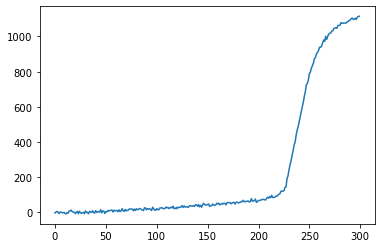

In [55]:
#加噪声
def Add_noise(pulse,noise_sigma):
    return pulse+np.random.normal(loc=0,scale=noise_sigma,size=pulse.shape)

Qpulse_noise=Add_noise(Qpulse,5)
plt.plot(Qpulse_noise[0,:])

(106373,)


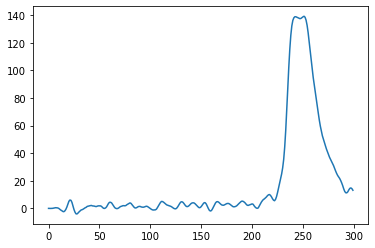

In [79]:
#计算A/E，输入为Qpulse_noise,带噪声的电荷波形，输出为AOE向量
def Partial(pulse,Npoint):
    py=np.array([1])
    px=np.zeros((Npoint+1,))
    px[0]=1
    px[Npoint]=-1
    return sig.lfilter(px,py,pulse,axis=1)

def MWA(pulse,Npoint):
    py=np.array([1])
    px=np.zeros((Npoint,))+1./Npoint
    return sig.lfilter(px,py,pulse,axis=1)

def NMWA(pulse,Npoint,Ntimes):
    for i in range(Ntimes):
        pulse = MWA(pulse, Npoint)
    return pulse
        
Apulse=Partial(NMWA(Qpulse_noise,5,3),5)
plt.plot(Apulse[0,:])
AOE=np.max(Apulse,axis=1)/Energy
print(AOE.shape)

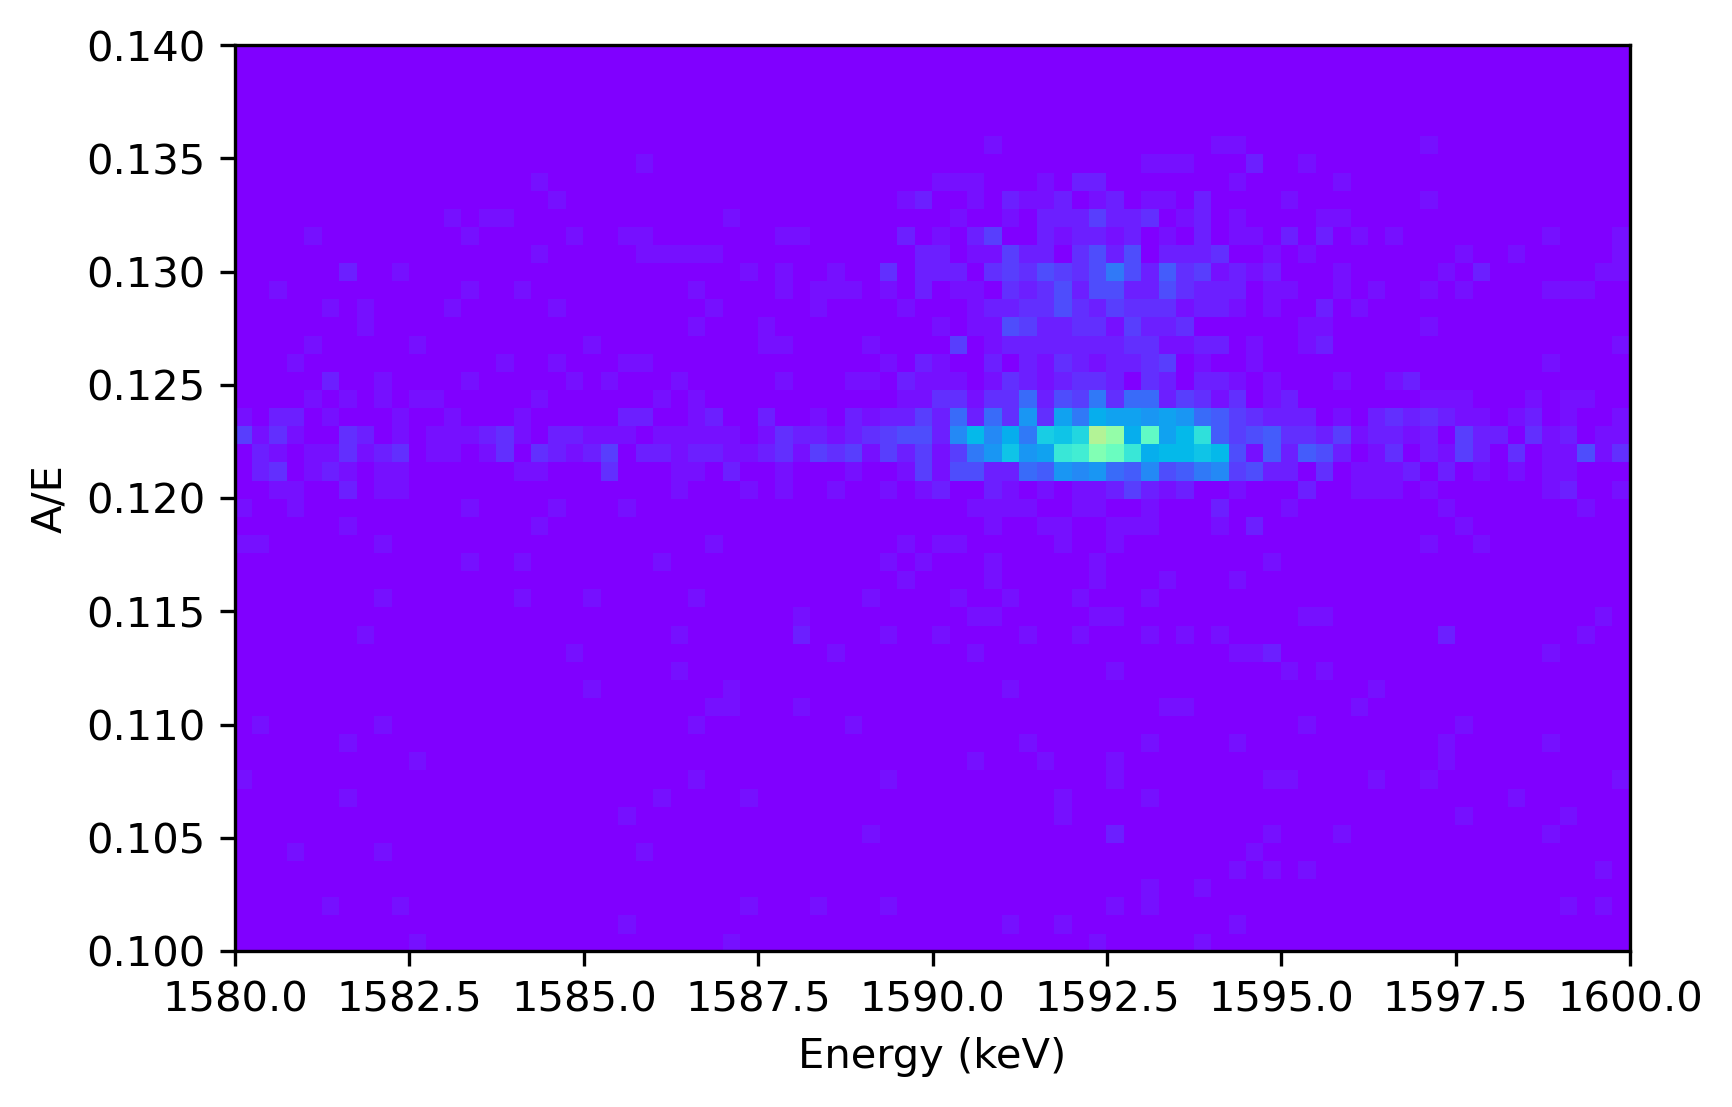

In [122]:
#归一，与实验相比较
###draw AOE-E distribution
####draw set

def heat_plot(plot_bins_,plot_range_,Energy_=Energy, AOE_=AOE):
    heatmap, xedges, yedges = np.histogram2d(Energy,AOE_ ,bins=plot_bins_,range=plot_range_)
    cmap_ = copy.copy(mpl.cm.get_cmap("rainbow"))
    cmap_.set_bad(color='white', alpha=0)
    #print(cmap_.get_bad())
    ax.pcolormesh(xedges, yedges,heatmap.T,cmap=cmap_,vmax=50)
    ax.set(xlabel='Energy (keV)',ylabel='A/E')  

#############
##plot heat map
fig, ax = plt.subplots(1,1,figsize=(6, 4),dpi=300)
heat_plot_bins=[80,50]
heat_plot_range=[[1580,1600],[0.1,.14]]

heat_plot(heat_plot_bins,heat_plot_range,Energy, AOE)

#plt_adjust()

#plt.show()

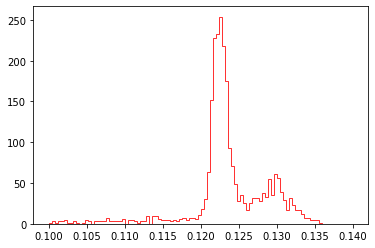

In [124]:
fig,ax_=plt.subplots(1,1)
spec_pss,bins_pss,patchs_pss=ax_.hist(AOE[abs(Energy-1592)<6],bins=100,range=[0.1,0.14],density=True,\
                                      histtype='step',log=False,linewidth=0.8,color='red',label='simulation')

In [ ]:
#比较1592和2103的A/E分布

fig,ax=plt.subplots(1,1)
AOE_DEP_event_pss=AOE[np.where(abs(Energy)<3)]
spec,bins,patchs=ax.hist(AOE_DEP_event,bins=plot_bins,range=plot_range,density=False,histtype='step',log=False,\
                      linewidth=0.8,color='red')
